## 데이터셋 생성

In [24]:
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import time
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [63]:
root_dir = "/mnt/d/Exa/data/"
makeset = tf.keras.utils.image_dataset_from_directory
# 이진 / 다중 분류 선택
class_type = "categorical"
assert class_type in ["binary", "categorical"], "typo in class_type"

In [79]:
batch_size = 64
image_size = (224, 224)
seed = 24542542 # random number
train_set = makeset(
    f"{root_dir}Training",
    image_size=image_size,
    batch_size=batch_size,
    seed=seed,
    label_mode=class_type
)
valid_set = makeset(
    f"{root_dir}Validation",
    image_size=image_size,
    batch_size=batch_size,
    seed=seed,
    label_mode=class_type
)
train_set.shuffle(buffer_size=200000)

Found 156925 files belonging to 10 classes.
Found 19999 files belonging to 10 classes.


<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [47]:
# 사전 설정 검사
category_num = 0
for d, l in train_set:
    _, category_num = l.shape
    print(f"data batch size: {d.shape} / label batch size: {l.shape}")
    break

if category_num == 1:
	assert class_type == "binary", "분류 설정 오류"
elif category_num >= 2:
	assert class_type == "categorical", "분류 설정 오류"
else:
	raise Exception("검증 데이터셋 오류")

data batch size: (16, 224, 224, 3) / label batch size: (16, 10)


## 모델 정의

### Swish 활성화 함수 클래스 정의

In [48]:
from tensorflow import keras
@keras.utils.register_keras_serializable() # 모델 저장 후 로드에 사용할 수 있도록하는 어노테이션
class Swish(tf.keras.layers.Layer):
    def call(self, x):
        return x * tf.keras.activations.sigmoid(x)

### SEBlock 정의

In [49]:
def SEBlock(reduction, channels, name):
    def block(inputs):
        x = layers.GlobalAveragePooling2D(name=f"{name}_Squeeze")(inputs)
        x = layers.Reshape((1, 1, channels), name=f"{name}_Reshape")(x)
        x = layers.Conv2D(channels // reduction, kernel_size=(1, 1), activation=Swish(), name=f"{name}_Reduce")(x)
        x = layers.Conv2D(channels, kernel_size=(1, 1), activation="sigmoid", name=f"{name}_Expand")(x)
        x = layers.multiply([inputs, x], name=f"{name}_Excite")
        return x
    return block

### MBConv 정의

In [50]:
from tensorflow.keras import layers, regularizers


def MBConv(kernel_size, expansion, input_channels, output_channels, strides, name):
    def block(inputs):
        x = inputs
        
        if expansion > 1:
            x = layers.Conv2D(filters=expansion * input_channels, kernel_size=(1, 1), use_bias=False, name=f"{name}_Expansion")(x)
            x = layers.BatchNormalization(name=f"{name}_BN-1")(x)
            x = Swish(name=f"{name}_Swish-1")(x)

        x = layers.DepthwiseConv2D(kernel_size=kernel_size, use_bias=False, padding='same', strides=strides, name=f"{name}_DWConv")(x)
        x = layers.BatchNormalization(name=f"{name}_BN-2")(x)
        x = Swish(name=f"{name}_Swish-2")(x)
        
        x = SEBlock(reduction=expansion * 4, channels=input_channels * expansion, name=f"{name}_SE")(x)

        x = layers.Conv2D(filters=output_channels, kernel_size=(1, 1), use_bias=False, name=f"{name}_PWConv")(x)
        x = layers.BatchNormalization(name=f"{name}_BN-3")(x)
        
        # 입출력 크기 동일한 경우 드롭아웃 및 잔차연결 적용
        if inputs.shape == x.shape:
            x = layers.Dropout(0.5, name=f"{name}_Dropout")(x)
            x = layers.add([x, inputs], name=f"{name}_Add")
        return x
    return block

### 모델 조립

In [51]:
model_config = [
    # kernel_size, expansion, input_channels, output_channels, strides, name
    # MBConv1, k3x3, C=16,  L=1
    (3, 1, 32,  16,  1, "Stage_2-1"),
    # MBConv6, k3x3, C=24,  L=2
    (3, 6, 16,  24,  2, "Stage_3-1"),
    (3, 6, 24,  24,  1, "Stage_3-2"),
    # MBConv6, k5x5, C=40,  L=2
    (5, 6, 24,  40,  2, "Stage_4-1"),
    (5, 6, 40,  40,  1, "Stage_4-2"),
    # MBConv6, k3x3, C=80,  L=3
    (3, 6, 40,  80,  2, "Stage_5-1"),
    (3, 6, 80,  80,  1, "Stage_5-2"),
    (3, 6, 80,  80,  1, "Stage_5-3"),
    # MBConv6, k5x5, C=112, L=3
    (5, 6, 80,  112, 1, "Stage_6-1"),
    (5, 6, 112, 112, 1, "Stage_6-2"),
    (5, 6, 112, 112, 1, "Stage_6-3"),
    # MBConv6, k5x5, C=192, L=3
    (5, 6, 112, 192, 2, "Stage_7-1"),
    (5, 6, 192, 192, 1, "Stage_7-2"),
    (5, 6, 192, 192, 1, "Stage_7-3"),
    (5, 6, 192, 192, 1, "Stage_7-4"),
    # MBConv6, k3x3, C=320, L=3
    (3, 6, 192, 320, 1, "Stage_8-1")
]
final_activation = "sigmoid" if class_type == "binary" else "softmax"

inputs = tf.keras.Input(shape=(224, 224, 3), name="Inputs")
x = layers.Rescaling(1./255, name="Rescaling")(inputs)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding="same", use_bias=False, name="Stage_1_Conv3x3")(x)
x = layers.BatchNormalization(name="Stage_1_BN")(x)
x = Swish(name="Stage_1_Swish")(x)

for cfg in model_config:
    x = MBConv(*cfg)(x) # model_config의 튜플 cfg로 설정된 MBConv 블록 연결

x = layers.Conv2D(filters=1280, kernel_size=(1, 1), use_bias=False, name="Stage_9_Conv1x1")(x)
x = layers.BatchNormalization(name="Stage_9_BN")(x)
x = Swish(name="Stage_9_Swish")(x)
x = layers.GlobalAveragePooling2D(name="Stage_9_Pooling")(x)
x = layers.Dense(category_num, activation=final_activation, name="Stage_9_FC")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)
loss_function = f"{class_type}_crossentropy" # 분류 과제에 맞는 손실함수 설정
model.compile(loss=loss_function, optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), metrics=["accuracy"])

# model.summary() # 모델 구조 확인용

### 학습

In [52]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 콜백함수 정의
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint_loss = ModelCheckpoint(
    "./model/test2-batch16-adam-lr002-dr05-loss.keras", 
    monitor="val_loss",
    mode="min", 
    save_best_only=True,
)
checkpoint_acc = ModelCheckpoint(
    "./model/test2-batch16-adam-lr002-dr05-acc.keras", 
    monitor="val_accuracy",
    mode="max", 
    save_best_only=True,
)

# 시간 측정 및 학습 실행
start = time.time()
history = model.fit(
    train_set,
    epochs=30,
    validation_data=valid_set,
    callbacks=[early_stopping, checkpoint_loss, checkpoint_acc]
)
end = time.time()
print(f"Time spent: {int((end - start) // 60)}m {(end - start) % 60:.3f}s")

Epoch 1/30
9808/9808 ━━━━━━━━━━━━━━━━━━━━ 391s 36ms/step - accuracy: 0.4255 - loss: 1.3388 - val_accuracy: 0.4362 - val_loss: 2.1844
Epoch 2/30
9808/9808 ━━━━━━━━━━━━━━━━━━━━ 341s 35ms/step - accuracy: 0.7917 - loss: 0.4827 - val_accuracy: 0.5113 - val_loss: 1.8940
Epoch 3/30
9808/9808 ━━━━━━━━━━━━━━━━━━━━ 343s 35ms/step - accuracy: 0.9194 - loss: 0.2153 - val_accuracy: 0.6090 - val_loss: 1.6370
Epoch 4/30
9808/9808 ━━━━━━━━━━━━━━━━━━━━ 339s 35ms/step - accuracy: 0.9532 - loss: 0.1314 - val_accuracy: 0.6139 - val_loss: 1.5392
Epoch 5/30
9808/9808 ━━━━━━━━━━━━━━━━━━━━ 338s 34ms/step - accuracy: 0.9660 - loss: 0.0979 - val_accuracy: 0.6314 - val_loss: 1.8984
Epoch 6/30
9808/9808 ━━━━━━━━━━━━━━━━━━━━ 339s 35ms/step - accuracy: 0.9735 - loss: 0.0772 - val_accuracy: 0.6522 - val_loss: 1.8358
Epoch 7/30
9808/9808 ━━━━━━━━━━━━━━━━━━━━ 338s 34ms/step - accuracy: 0.9787 - loss: 0.0642 - val_accuracy: 0.6366 - val_loss: 1.7458
Epoch 8/30
9808/9808 ━━━━━━━━━━━━━━━━━━━━ 336s 34ms/step - accuracy: 

### 학습 결과 확인

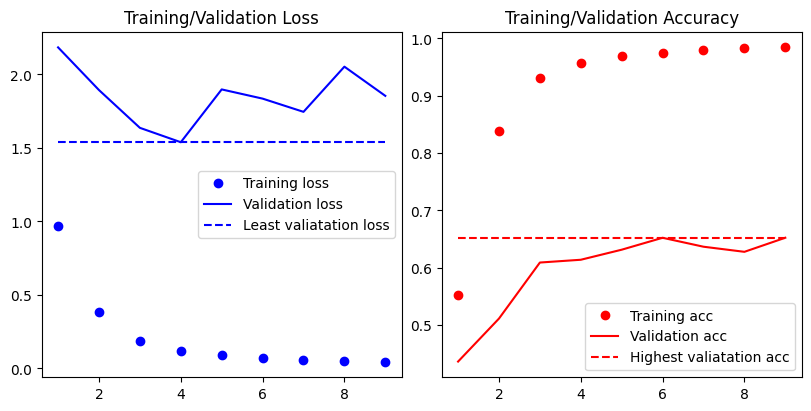

In [54]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
figure, axis = plt.subplots(1, 2, figsize=(8, 4), layout="constrained")
# 손실 그래프
axis[0].set_title("Training/Validation Loss")
axis[0].plot(epochs, loss, "bo", label="Training loss")
axis[0].plot(epochs, val_loss, "b", label="Validation loss")
axis[0].plot(epochs, [min(val_loss)] * len(epochs), "b--", label="Least valiatation loss")
axis[0].legend()
# 정확도 그래프
axis[1].set_title("Training/Validation Accuracy")
axis[1].plot(epochs, acc, "ro", label="Training acc")
axis[1].plot(epochs, val_acc, "r", label="Validation acc")
axis[1].plot(epochs, [max(val_acc)] * len(epochs), "r--", label="Highest valiatation acc")
axis[1].legend()

### 최종 검증

In [80]:
test_set = makeset(
    f"{root_dir}Test",
    image_size=image_size,
    batch_size=batch_size,
    seed=seed,
    label_mode=class_type
)

Found 3075 files belonging to 10 classes.


In [87]:
best_model = tf.keras.models.load_model("./model/batch64-adam-lr002-dr05-acc.keras")
print(f"Test Accuracy: {best_model.evaluate(test_set)[1]}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.6860 - loss: 1.5413
Test Accuracy: 0.692032516002655
